In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Network Parameters
num_input = 38
timesteps = 80 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [3]:
def read_sensor(filename):
#     print(filename)
    f_sensor=open(filename)  
    dataset=pd.read_csv(f_sensor)
    
    data_x = np.array(dataset.iloc[:, 1:39])
#     print(data_x.shape)
    
    data_y = np.array(dataset.iloc[:, 40:41])
#     print(data_y.shape)

    return data_x, data_y


def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    cur_dir = 1
    if(all_foot[0] == 'L'):
        cur_dir = 0
    strike_times.append([0.0, cur_dir])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times.append([length/25.0, 0.5])
#     print(strike_times[0:10])
#     print(len(strike_times))

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])
         
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x_part, data_y_part = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    window_y_part = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x_part))
    
    data_x, window_y = [], []
    for i in range(len(data_x_part)-timesteps):
        x=data_x_part[i:i+timesteps]
        y=window_y_part[i+timesteps]
        data_x.append(x)
        window_y.append(y)
    
    return data_x, window_y

In [4]:
step_data_list = []
for i in range(1,5):
    step_data_list.append([i, 1, '1L', 'GD'])
    step_data_list.append([i, 1, '1L', 'WC'])
#     step_data_list.append([i, 1, '2R', 'GD'])
#     step_data_list.append([i, 1, '2R', 'WC'])
#     step_data_list.append([i, 2, '1L', 'WC'])
#     step_data_list.append([i, 2, '2R', 'WC'])
    
print(step_data_list)

[[1, 1, '1L', 'GD'], [1, 1, '1L', 'WC'], [2, 1, '1L', 'GD'], [2, 1, '1L', 'WC'], [3, 1, '1L', 'GD'], [3, 1, '1L', 'WC'], [4, 1, '1L', 'GD'], [4, 1, '1L', 'WC']]


In [5]:
data_x, window_y = [], []
for i in step_data_list:
    data_x_segement, window_y_segement = add_data(i[0], i[1], i[2], i[3])
    data_x.extend(data_x_segement)
    window_y.extend(window_y_segement)
    
print(len(data_x)) #93638
print(len(window_y))

30545
30545


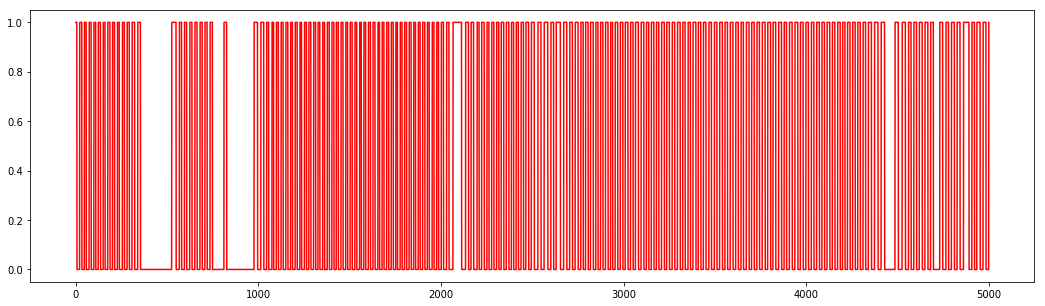

In [17]:
plt.figure(figsize=(18, 5))
start=20000
end=25000
#time back to 0
# plt.plot([i[0][0] for i in data_x[start:end]], [i[0] for i in window_y[start:end]], 'r')
plt.plot([i[0] for i in window_y[start:end]], 'r')
plt.show()

In [6]:
order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x = [data_x[i] for i in order]
train_y = [window_y[i] for i in order]

print(len(train_x))

30545


In [14]:
step_test_list = []
for i in range(5,7):
    step_test_list.append([i, 1, '1L', 'GD'])
    step_test_list.append([i, 1, '1L', 'WC'])
#     step_test_list.append([i, 1, '2R', 'GD'])
#     step_test_list.append([i, 1, '2R', 'WC'])
#     step_test_list.append([i, 2, '1L', 'WC'])
#     step_test_list.append([i, 2, '2R', 'WC'])
    
print(step_test_list)

[[5, 1, '1L', 'GD'], [5, 1, '1L', 'WC'], [6, 1, '1L', 'GD'], [6, 1, '1L', 'WC']]


In [16]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, window_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(window_y_segement)
    
print(len(test_x))
print(len(test_y))

16259
16259


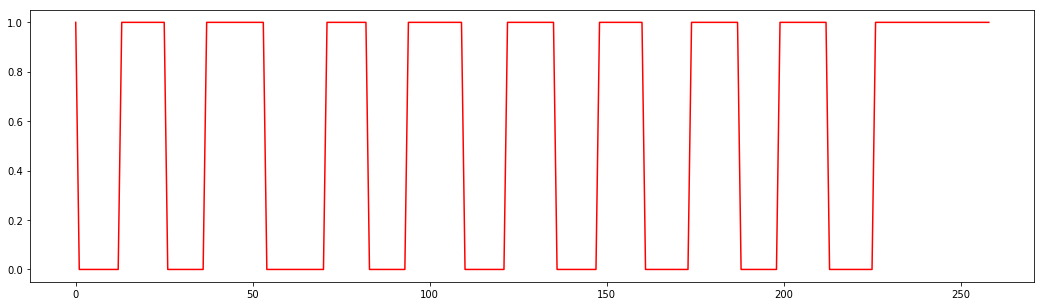

In [17]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y[start:end]], 'r')
plt.show()

In [18]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
    return lstm_cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
        #'out':tf.Variable(tf.zeros([1]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

In [19]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
train_x.extend(train_x[0:batch_size])
train_y.extend(train_y[0:batch_size])
training_steps = 6001

In [20]:
config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allocator_type = 'BFC'
# config.gpu_options.per_process_gpu_memory_fraction = 0.40
with tf.Session(graph=graph, config=config) as session:
#     saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#     saver.restore(session, "lstm_check/my-model-gpu-batch-test-add-data.ckpt-10000")
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
        _, l, predictions, m = session.run([optimizer, loss, logits,mean_train], feed_dict = feed_dict)
        if (step % 200 == 0):
            print('Loss at step %d: %f' % (step, l))
        if (step % 2000 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-batch-test-add-data-10wan-1time.ckpt', global_step=step+6000)
    test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})

Initialized
Loss at step 0: 3.741857
Loss at step 200: 0.241763
Loss at step 400: 0.171203
Loss at step 600: 0.116074
Loss at step 800: 0.110646
Loss at step 1000: 0.105346
Loss at step 1200: 0.105956
Loss at step 1400: 0.122867
Loss at step 1600: 0.106561
Loss at step 1800: 0.104191
Loss at step 2000: 0.093203
Loss at step 2200: 0.105876
Loss at step 2400: 0.100860
Loss at step 2600: 0.083761
Loss at step 2800: 0.096928
Loss at step 3000: 0.091478
Loss at step 3200: 0.078373
Loss at step 3400: 0.061523
Loss at step 3600: 0.093919
Loss at step 3800: 0.074641
Loss at step 4000: 0.082040
Loss at step 4200: 0.061162
Loss at step 4400: 0.087084
Loss at step 4600: 0.074352
Loss at step 4800: 0.094160
Loss at step 5000: 0.058315
Loss at step 5200: 0.062790
Loss at step 5400: 0.074256
Loss at step 5600: 0.070384
Loss at step 5800: 0.076990
Loss at step 6000: 0.064514


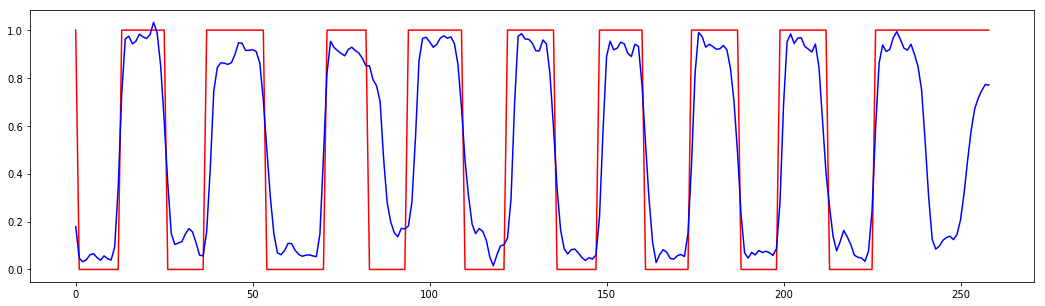

In [21]:
plt.figure(figsize=(18, 5))
start = 16000
end =17000
plt.plot([i[0] for i in test_y[start:end]], 'r')
plt.plot([i[0] for i in test_logits[start:end]], 'b')
plt.show()

In [13]:
print(test_loss)

count = 0
for i in range(0, len(test_x)):
    if(test_y[i][0] == round(test_logits[i][0])):
        count += 1;
print(count/len(test_x))

0.0644709
0.9137338353249305
